The following is from [this article](https://medium.com/towards-data-science/q-learning-for-beginners-2837b777741) in Medium

In [1]:
import random

import gym
import matplotlib.pyplot as plt
import numpy as np

# ❄️ I. Frozen Lake

Frozen Lake is a simple environment composed of tiles, where the AI has to move from an initial tile to a goal. Tiles can be a safe frozen lake ✅, or a hole ❌ that gets you stuck forever. The AI, or agent, has 4 possible actions: go ◀️LEFT, 🔽DOWN, ▶️RIGHT, or 🔼UP. The agent must learn to avoid holes in order to reach the goal in a minimal number of actions. By default, the environment is always in the same configuration. In the environment’s code, each tile is represented by a letter as follows:

Let’s initialize the environment thanks to the gym library. There are two versions of the game: one with slippery ice, where selected actions have a random chance of being disregarded by the agent; and a non-slippery one, where actions cannot be ignored. We'll use the non-slippery one to begin with because it's easier to understand.

In [2]:
environment = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")

In [3]:
environment.reset()

(0, {'prob': 1})

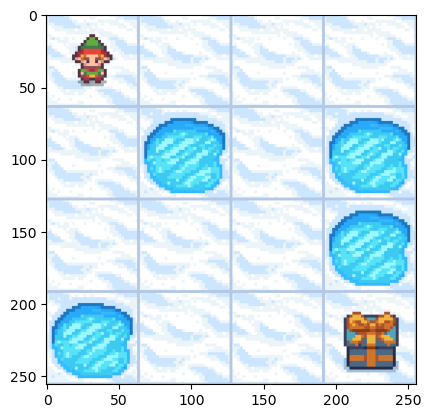

In [4]:
plt.imshow(environment.render());

# 🏁 II. Q-table

In ❄️Frozen Lake, there are 16 tiles, which means our agent can be found in 16 different positions, called states. For each state, there are 4 possible actions: go ◀️LEFT, 🔽DOWN, ▶️RIGHT, and 🔼UP. Learning how to play Frozen Lake is like learning which action you should choose in every state. To know which action is the best in a given state, we would like to assign a quality value to our actions. We have 16 states and 4 actions, so want to calculate 16 x 4 = 64 values.

A nice way of representing it is using a table, known as a Q-table, where rows list every state s and columns list every action a. In this Q-table, each cell contains a value Q(s, a), which is the value (quality) of the action a in the state s (1 if it’s the best action possible, 0 if it’s really bad). When our agent is in a particular state s, it just has to check this table to see which action has the highest value. Taking the action with the highest value makes sense but we’ll see later that we can design something even better…

Let’s create our Q-table and fill it with zeros since we still have no idea of the value of each action in each state.

In [5]:
# Our table has the following dimensions:
# (rows x columns) = (states x actions) = (16 x 4)
qtable = np.zeros((16, 4))

In [6]:
qtable

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [7]:
# Alternatively, the gym library can also directly
# give us the number of states and actions using
# "env.observation_space.n" and "env.action_space.n"
nb_states = environment.observation_space.n  # = 16
nb_actions = environment.action_space.n  # = 4
qtable = np.zeros((nb_states, nb_actions))

Great! We have our Q-table with 16 rows (our 16 states) and 4 columns (our 4 actions) as expected. Let’s try to see what we can do next: every value is set to zero, so we have no information at all. Let’s say that the agent takes a random action: ◀️LEFT, 🔽DOWN, ▶️RIGHT, or 🔼UP.

We can use the `random` library with the `choice` method to randomly choose an action.

In [8]:
random.choice(["LEFT", "DOWN", "RIGHT", "UP"])

'DOWN'

Wait, actually the agent is currently on the initial state S, which means only two actions are possible: ▶️RIGHT and 🔽DOWN. The agent can also take the actions 🔼UP and ◀️LEFT, but it won't move: its state doesn't change. Therefore, we do not put any constraint on what actions are possible: the agent will naturally understand that some of them don't do anything.

We can keep using `random.choice()`, but the `gym` library already implements a method to randomly choose an action. It might save us some hassle later, so let's try it.

In [9]:
environment.action_space.sample()

3

Oops... this time it's a number. We could read gym's documentation but it is quite scarce unfortunately. No worries though, we can check the source code on GitHub to understand what these numbers mean. It's actually super straightforward:

Okay, now that we understand how gym connects numbers to directions, let's try to use it to move our agent to the right ▶️. This time, it can be performed using the `step(action)` method. We can try to directly provide it the number 2, corresponding to the direction we chose (right), and check if the agent moved.

In [10]:
environment.step(2)

(1, 0.0, False, False, {'prob': 1.0})

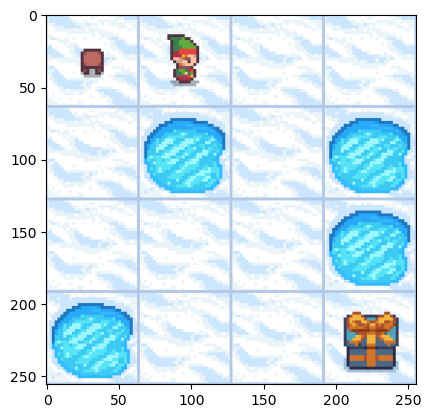

In [11]:
plt.imshow(environment.render());

Huzzah! The red square moved from the initial state S to the right: our prediction was correct. And that's all we need to know in order to interact with the environment:

1. How to randomly choose an action using `action_space.sample()`;
2. How to implement this action and move our agent in the desired direction with `step(action)`.

To be completely exhaustive, we can add:

1. How to display the current map to see what we’re doing with `render()`;
2. How to restart the game when the agent falls into a hole or reaches the goal G with `reset()`.

Now that we understand how to interact with our `gym` environment, let's go back to our algorithm. In reinforcement learning, agents are rewarded by the environment when they accomplish a predefined goal. In ❄️Frozen Lake, the agent is only rewarded when it reaches the state G (see [the source code](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py#L85)). We cannot control this reward, it is set in the environment: it's 1 when the agent reaches G, and 0 otherwise.

Let’s print it every time we implement an action. The reward is given by the method `step(action)`.

Reward = 0.0


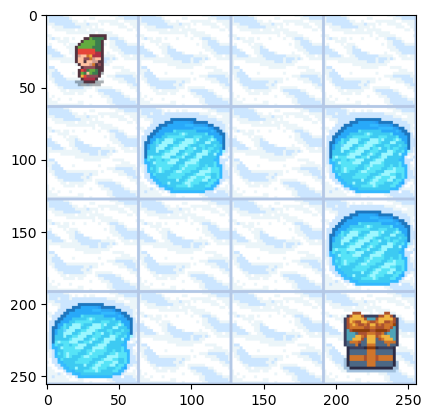

In [12]:
action = environment.action_space.sample()

# 2. Implement this action and move the agent in the desired direction
new_state, reward, terminated, truncated, info = environment.step(action)

# Display the results (reward and map)
plt.imshow(environment.render())
print(f"Reward = {reward}")

The reward is indeed 0… 😱 wow, I guess we’re in a pickle, because only one state can give us a positive reward in the entire game. How are we supposed to take the right directions at the very beginning when the only validation we have is at the very end? If we ever want to see a reward of 1, we’d need to be lucky enough to find the correct sequence of actions by chance. Unfortunately, that’s exactly how it works… the Q-table will remain filled with zeros until the agent randomly reaches the goal G.

The problem would be much simpler if we could have intermediate, smaller rewards to guide our path towards the goal G. Alas, this is actually one of the main issues of reinforcement learning: this phenomenon, called sparse rewards, makes agents very difficult to train on problems where the only reward is at the end of a long sequence of actions. Different techniques were proposed to mitigate this issue, but we’ll talk about it another time.

# 🤖 III. Q-learning

Let’s go back to our problem. Okay, we need to be lucky enough to find the goal G by accident. But once it’s done, how to backpropagate the information to the initial state? The 🤖Q-learning algorithm offers a clever solution to this issue. We need to update the value of our state-action pairs (each cell in the Q-table) considering 1/ the reward for reaching the next state, and 2/ the highest possible value in the next state.

We know we get a reward of 1 when we move to G. As we just said, the value of the state next to G (let’s call it G-1) with the relevant action to reach G is increased thanks to the reward. Okay good, end of the episode: the agent won and we restart the game. Now, the next time the agent is in a state next to G-1, it will increase the value of this state (let’s call it G-2) with the relevant action to reach G-1. The next time the agent is in a state next to G-2, it will do the same. Rinse and repeat, until the update reaches the initial state S.

Actually, we almost found the true Q-learning update formula with common sense. The nuance we’re looking for adds two parameters:

- α is the 💡learning rate (between 0 and 1), which is how much we should change the original Q(sₜ, aₜ) value. If α = 0, the value never changes, but if α = 1, the value changes extremely fast. In our attempt, we didn’t limit the learning rate so α = 1. But this is too fast in reality: the reward and the maximum value in the next state quickly overpower the current value. We need to find a balance between the importance of past and new knowledge.
- γ is the 📉discount factor (between 0 and 1), which determines how much the agent cares about future rewards compared to immediate ones (as the saying goes, “a bird in the hand is worth two in the bush”). If γ = 0, the agent only focuses on immediate rewards , but if γ = 1, any potential future reward has the same value than current ones. In ❄️Frozen Lake, we want a high discount factor since there’s only one possible reward at the very end of the game.

With the real Q-learning algorithm, the new value is calculated as follows:

<img src="equ_1.webp" style="width:800px;height:50px;background-color:white">

Okay, let’s try this new formula before implementing it. Once again, we can pretend that our agent is next to the goal G for the first time. We can update the state-action pair to win the game using our formula: Q{new}(G-1, aₜ) = 0 + α · (1 + γ · 0 − 0). We can assign arbitrary values to α and γ to calculate the result. With α = 0.5 and γ = 0.9, we get Q{new}(G-1, aₜ) = 0 + 0.5 · (1 + 0.9 · 0 − 0) = 0.5. The second time the agent is in this state, we would get: Q{new}(G-1, aₜ) = 0.5 + 0.5 · (1 + 0.9 · 0 − 0.5) = 0.75, then 0.875, 0.9375, 0.96875, etc.

<img src="figure_1.gif" style="width:600px;height:600px;background-color:white">

So training our agent in code means:

1. Choosing a random action (using `action_space.sample()`) if the values in the current state are just zeros. Otherwise, we take the action with the highest value in the current state with the function `np.argmax()`;
2. Implementing this action by moving in the desired direction with `step(action)`;
3. Updating the value of the original state with the action we took, using information about the new state and the reward given by `step(action)`;

We keep repeating these 3 steps until the agent gets stuck in a hole or reaches the goal G. When it happens, we just restart the environment with `reset()` and start a new episode until we hit 1,000 episodes. Additionally, we can plot the outcome of each run (failure if it didn't reach the goal, success otherwise) to observe the progress of our agent.

In [13]:
plt.rcParams["figure.dpi"] = 300
plt.rcParams.update({"font.size": 17})

In [14]:
# We re-initialize the Q-table
qtable = np.zeros((environment.observation_space.n, environment.action_space.n))

In [15]:
# Hyperparameters
episodes = 1000  # Total number of episodes
alpha = 0.5  # Learning rate
gamma = 0.9  # Discount factor

In [16]:
# List of outcomes to plot
outcomes = []

In [17]:
print("Q-table before training:")
print(qtable)

Q-table before training:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [18]:
# Training
for _ in range(episodes):
    state = environment.reset()[0]
    terminated = False

    # By default, we consider our outcome to be a failure
    outcomes.append("Failure")

    # Until the agent gets stuck in a hole or reaches the goal, keep training it
    while not terminated:
        # Choose the action with the highest value in the current state
        if np.max(qtable[state]) > 0:
            action = np.argmax(qtable[state])

        # If there's no best action (only zeros), take a random one
        else:
            action = environment.action_space.sample()

        # Implement this action and move the agent in the desired direction
        new_state, reward, terminated, truncated, info = environment.step(action)

        # Update Q(s,a)
        qtable[state, action] = qtable[state, action] + alpha * (
            reward + gamma * np.max(qtable[new_state]) - qtable[state, action]
        )

        # Update our current state
        state = new_state

        # If we have a reward, it means that our outcome is a success
        if reward:
            outcomes[-1] = "Success"

In [19]:
print("Q-table after training:")
print(qtable)

Q-table after training:
[[0.         0.         0.59049    0.        ]
 [0.         0.         0.6561     0.        ]
 [0.         0.729      0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.03075469 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.81       0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.18225    0.        ]
 [0.         0.48726563 0.         0.        ]
 [0.         0.9        0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.80683594 0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         0.        ]]


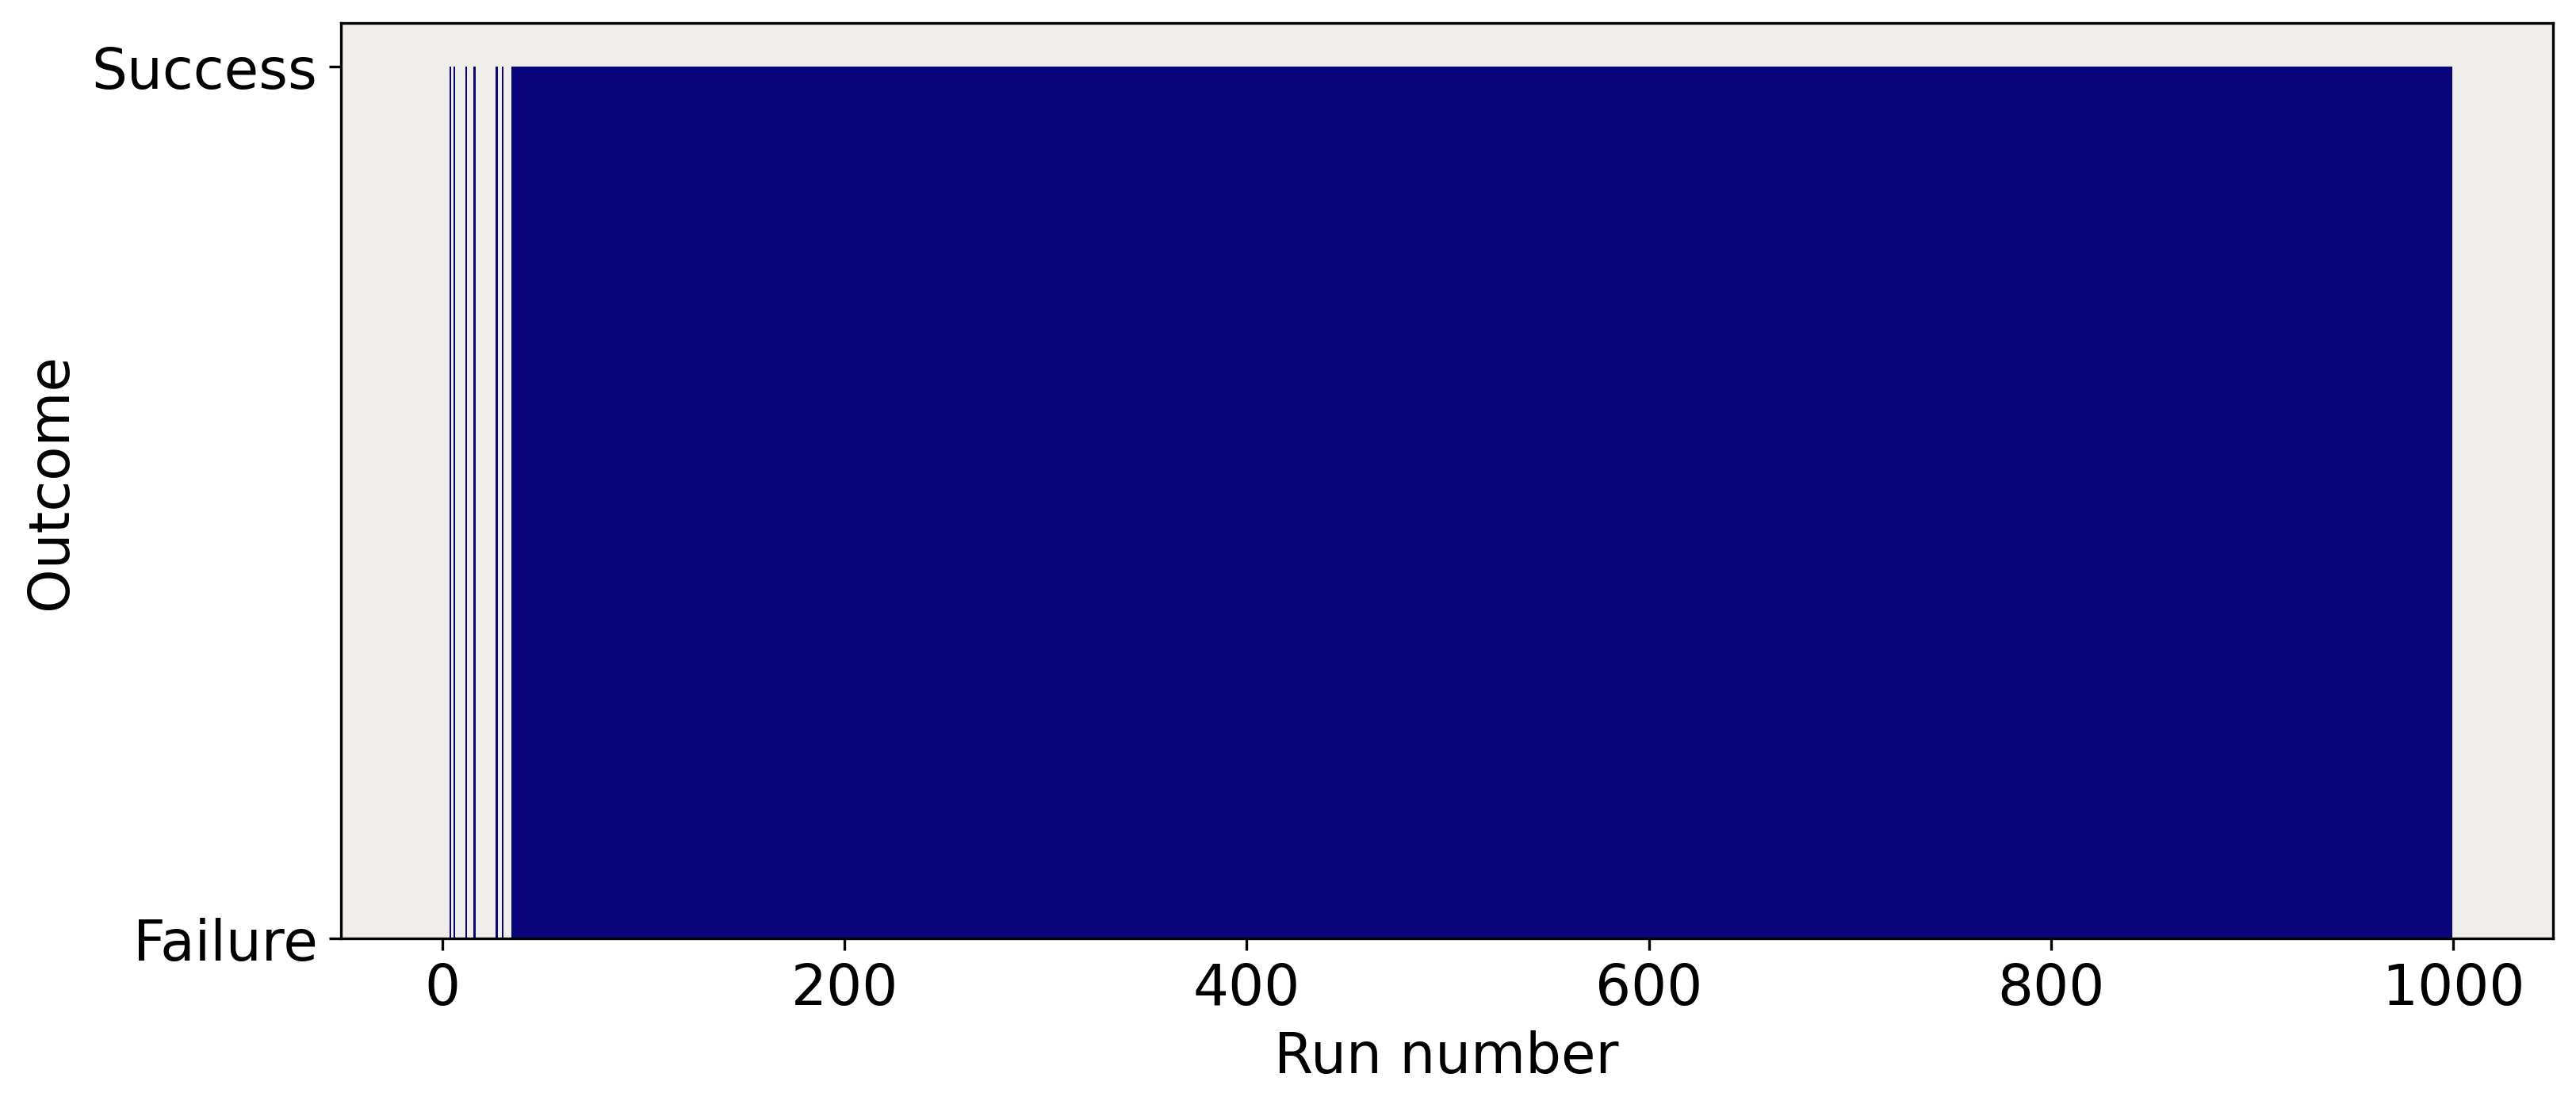

In [20]:
# Plot outcomes
plt.figure(figsize=(12, 5))
plt.xlabel("Run number")
plt.ylabel("Outcome")
ax = plt.gca()
ax.set_facecolor("#efeeea")
plt.bar(range(len(outcomes)), outcomes, color="#0A047A", width=1.0)
plt.show();

The agent is trained! Each blue bar on the figure corresponds to a win, so we can see that the agent had a hard time finding the goal at the beginning of the training. But once it found it several times in a row, it began to consistently win. 🥳 The trained Q-table is also very interesting: these values indicate the unique sequence of actions the agent learned to reach the goal.

Now let’s see how it performs by evaluating it on 100 episodes. We consider that the training is over, so we don’t need to update the Q-table anymore. To see how the agent performs, we can calculate the percentage of times the it managed to reach the goal (success rate).

In [21]:
episodes = 100
nb_success = 0

# Evaluation
for _ in range(100):
    state = environment.reset()[0]
    terminated = False

    # Until the agent gets stuck or reaches the goal, keep training it
    while not terminated:
        # Choose the action with the highest value in the current state
        if np.max(qtable[state]) > 0:
            action = np.argmax(qtable[state])

        # If there's no best action (only zeros), take a random one
        else:
            action = environment.action_space.sample()

        # Implement this action and move the agent in the desired direction
        new_state, reward, terminated, truncated, info = environment.step(action)

        # Update our current state
        state = new_state

        # When we get a reward, it means we solved the game
        nb_success += reward

In [22]:
# Let's check our success rate!
print(f"Success rate = {nb_success/episodes*100}%")

Success rate = 100.0%


Not only our agent has been trained, but it manages to hit a 100% success rate. Great job everyone, the non-slippery ❄️Frozen Lake is solved!

We can even visualize the agent moving on the map by executing the code below and print the sequence of actions it took to check if it’s the best one.

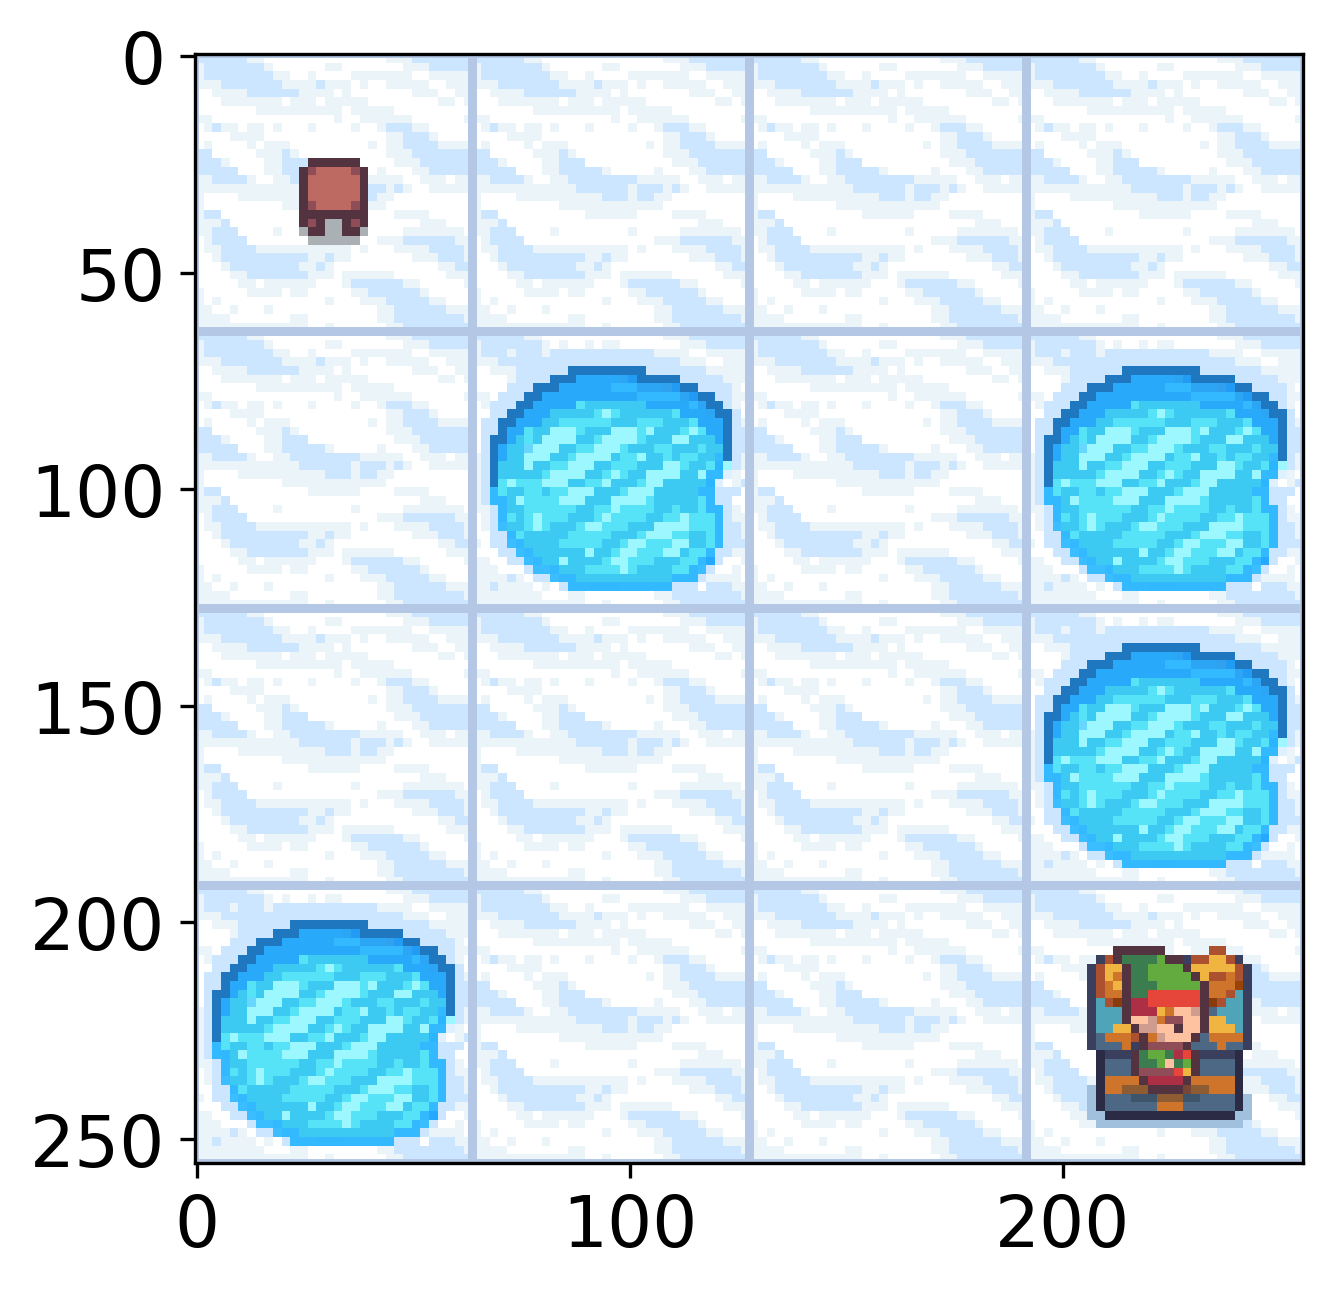

In [23]:
import time

from IPython.display import clear_output

state = environment.reset()[0]
terminated = False
sequence = []

while not terminated:
    # Choose the action with the highest value in the current state
    if np.max(qtable[state]) > 0:
        action = np.argmax(qtable[state])

    # If there's no best action (only zeros), take a random one
    else:
        action = environment.action_space.sample()

    # Add the action to the sequence
    sequence.append(action)

    # Implement this action and move the agent in the desired direction
    new_state, reward, terminated, truncated, info = environment.step(action)

    # Update our current state
    state = new_state

    # Update the render
    clear_output(wait=True)
    plt.imshow(environment.render())
    time.sleep(1)

In [24]:
print(f"Sequence = {sequence}")

Sequence = [2, 2, 1, 1, 1, 2]


The agent can learn several correct sequence of actions: [2, 2, 1, 1, 1, 2], [1, 1, 2, 2, 1, 2], etc. The good thing is there’s only 6 actions in our sequence, which was the minimum possible number of actions we counted: it means that our agent learned to solve the game in an optimal way. In the case of [2, 2, 1, 1, 1, 2], which corresponds to RIGHT → RIGHT → DOWN → DOWN → DOWN → RIGHT, it’s exactly the sequence we predicted at the very beginning of the article. 📣

# 📐 IV. Epsilon-Greedy algorithm

Despite this success, there’s something that bothers me with our previous approach: the agent always chooses the action with the highest value. So whenever a state-action pair starts having a non-zero value, the agent will always choose it. The other actions will never be taken, which means we’ll never update their value… But what if one of these actions was better than the one the agent always takes? Shouldn’t we encourage the agent to try news things from time to time and see if it can improve?

In other words, we want to allow our agent to either:

- Take the action with the highest value (exploitation);
- Choose a random action to try to find even better ones (exploration).

A tradeoff between these two behaviors is important: if the agent only focuses on exploitation, it cannot try new solutions and thus doesn’t learn anymore. On the other hand, if the agent only takes random actions, the training is pointless since it doesn’t use the Q-table. So we want to change this parameter over time: at the beginning of the training, we want to explore the environment as much as possible. But exploration becomes less and less interesting, as the agent already knows every possible state-action pairs. This parameter represents the amount of randomness in the action selection.

This technique is commonly called the epsilon-greedy algorithm, where epsilon is our parameter. It is a simple but extremely efficient method to find a good tradeoff. Every time the agent has to take an action, it has a probability ε of choosing a random one, and a probability 1-ε of choosing the one with the highest value. We can decrease the value of epsilon at the end of each episode by a fixed amount (linear decay), or based on the current value of epsilon (exponential decay).

<img src="figure_2.gif" style="width:600px;height:300px;background-color:white">

Let’s implement a linear decay. Beforehand, I’d like to see how the curve looks like with arbitrary parameters. We’ll start with ε = 1 to be in full exploration mode, and decrease this value by 0.001 after each episode.

Okay now that we have a sound understanding of it, we can implement it for real and see how it changes the agent’s behavior.

In [25]:
qtable = np.zeros((environment.observation_space.n, environment.action_space.n))

In [26]:
# Hyperparameters
episodes = 1000  # Total number of episodes
alpha = 0.5  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Amount of randomness in the action selection
epsilon_decay = 0.001  # Fixed amount to decrease

In [27]:
# List of outcomes to plot
outcomes = []

In [28]:
print("Q-table before training:")
print(qtable)

Q-table before training:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [29]:
# Training
for _ in range(episodes):
    state = environment.reset()[0]
    terminated = False

    # By default, we consider our outcome to be a failure
    outcomes.append("Failure")

    # Until the agent gets stuck in a hole or reaches the goal, keep training it
    while not terminated:
        # Generate a random number between 0 and 1
        rnd = np.random.random()

        # If random number < epsilon, take a random action
        if rnd < epsilon:
            action = environment.action_space.sample()
        # Else, take the action with the highest value in the current state
        else:
            action = np.argmax(qtable[state])

        # Implement this action and move the agent in the desired direction
        new_state, reward, terminated, truncated, info = environment.step(action)

        # Update Q(s,a)
        qtable[state, action] = qtable[state, action] + alpha * (
            reward + gamma * np.max(qtable[new_state]) - qtable[state, action]
        )

        # Update our current state
        state = new_state

        # If we have a reward, it means that our outcome is a success
        if reward:
            outcomes[-1] = "Success"

    # Update epsilon
    epsilon = max(epsilon - epsilon_decay, 0)

In [30]:
print("Q-table after training:")
print(qtable)

Q-table after training:
[[0.531441   0.59049    0.59049    0.531441  ]
 [0.531441   0.         0.6561     0.59048987]
 [0.59048995 0.729      0.59048662 0.65609999]
 [0.65609958 0.         0.55441513 0.59018429]
 [0.59049    0.6561     0.         0.531441  ]
 [0.         0.         0.         0.        ]
 [0.         0.81       0.         0.65609929]
 [0.         0.         0.         0.        ]
 [0.6561     0.         0.729      0.59049   ]
 [0.6561     0.81       0.81       0.        ]
 [0.729      0.9        0.         0.729     ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.80999979 0.9        0.72899995]
 [0.81       0.9        1.         0.81      ]
 [0.         0.         0.         0.        ]]


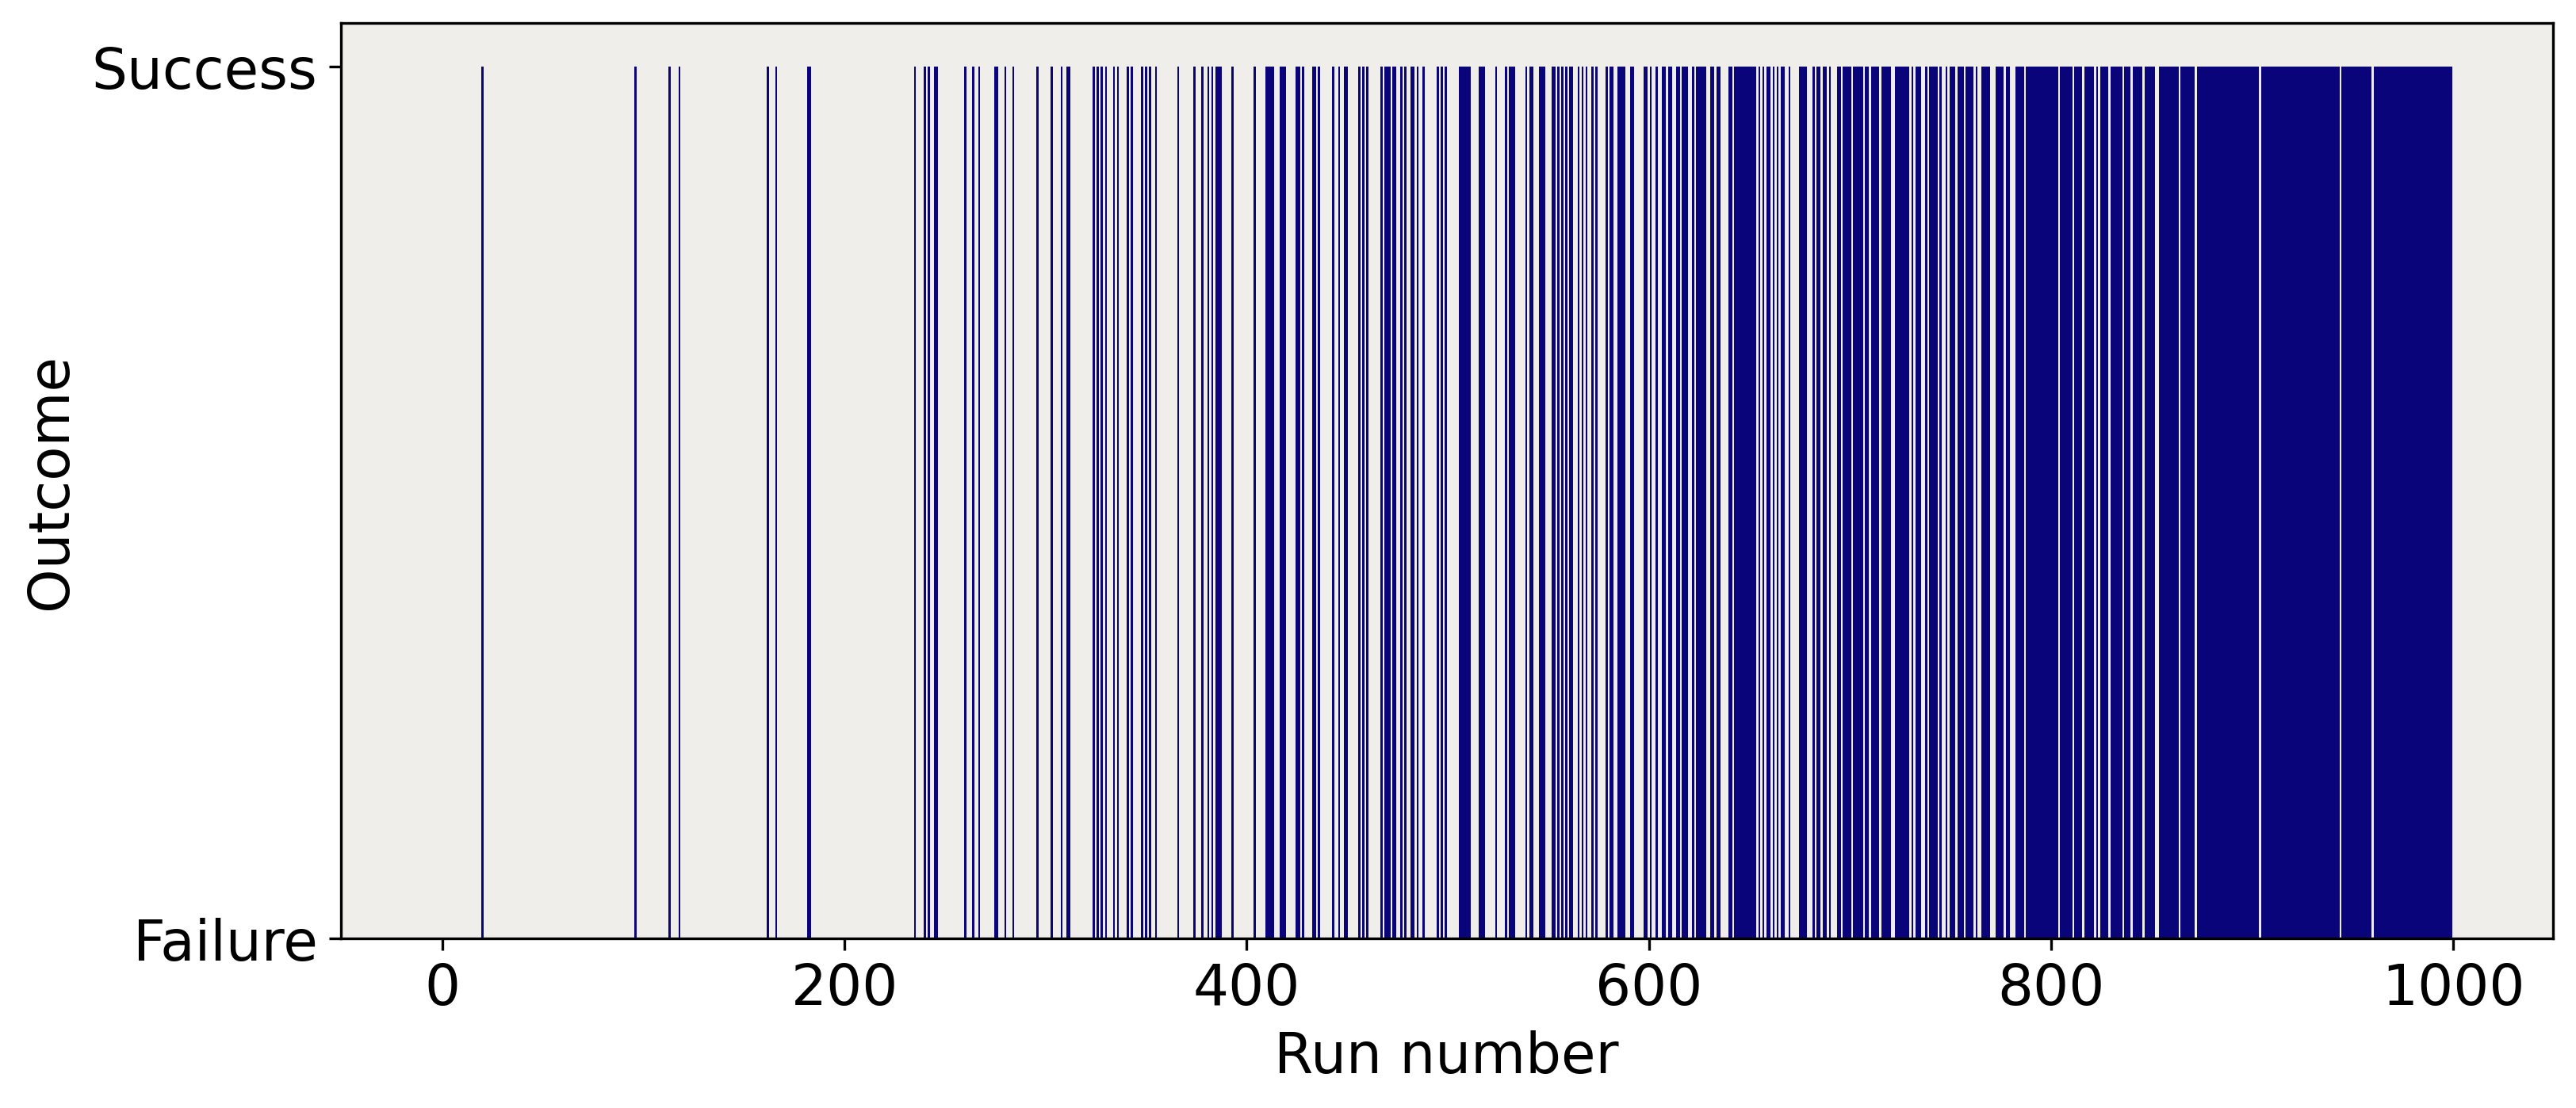

In [31]:
# Plot outcomes
plt.figure(figsize=(12, 5))
plt.xlabel("Run number")
plt.ylabel("Outcome")
ax = plt.gca()
ax.set_facecolor("#efeeea")
plt.bar(range(len(outcomes)), outcomes, color="#0A047A", width=1.0)
plt.show();

Hey, the agent takes more time to consistently win the game now! And the Q-table has a lot more non-zero values than the previous one, which means the agent has learned several sequences of actions to reach the goal. It is understandable, since this new agent is forced to explore state-action pairs instead of always exploiting ones with non-zero values.

Let’s see if it’s as successful as the previous one to win the game. In evaluation mode, we don’t want exploration anymore because the agent is trained now.

In [32]:
episodes = 100
nb_success = 0

# Evaluation
for _ in range(100):
    state = environment.reset()[0]
    terminated = False

    # Until the agent gets stuck or reaches the goal, keep training it
    while not terminated:
        # Choose the action with the highest value in the current state
        action = np.argmax(qtable[state])

        # Implement this action and move the agent in the desired direction
        new_state, reward, terminated, truncated, info = environment.step(action)

        # Update our current state
        state = new_state

        # When we get a reward, it means we solved the game
        nb_success += reward

In [33]:
# Let's check our success rate!
print(f"Success rate = {nb_success/episodes*100}%")

Success rate = 100.0%


Phew, it’s another 100% success rate! We didn’t degrade the model. 😌 The benefits of this approach might not be obvious in this example, but our model became less static and more flexible. It learned different paths (sequences of actions) from S to G instead of just one as in the previous approach. More exploration can degrade performance but it’s necessary to train agents that can adapt to new environments.

# ❄️ IV. Challenge: slippery Frozen Lake

We didn’t solve the entire ❄️Frozen Lake environment: we only trained an agent on the non-slippery version, using `is_slippery = False` during initialization. In the slippery variant, the action the agent takes only has 33% chance of succeeding. In case of failure, one of the three other actions is randomly taken instead. This feature adds a lot of randomness to the training, which makes things more difficult for our agent. Let's see how well our code is doing in this new environment...

In [34]:
environment = gym.make("FrozenLake-v1", is_slippery=True)
environment.reset()

(0, {'prob': 1})

In [35]:
# We re-initialize the Q-table
qtable = np.zeros((environment.observation_space.n, environment.action_space.n))

In [36]:
# Hyperparameters
episodes = 1000  # Total number of episodes
alpha = 0.5  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Amount of randomness in the action selection
epsilon_decay = 0.001  # Fixed amount to decrease

In [37]:
# List of outcomes to plot
outcomes = []

In [38]:
print("Q-table before training:")
print(qtable)

Q-table before training:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [39]:
# Training
for _ in range(episodes):
    state = environment.reset()[0]
    terminated = False

    # By default, we consider our outcome to be a failure
    outcomes.append("Failure")

    # Until the agent gets stuck in a hole or reaches the goal, keep training it
    while not terminated:
        # Generate a random number between 0 and 1
        rnd = np.random.random()

        # If random number < epsilon, take a random action
        if rnd < epsilon:
            action = environment.action_space.sample()
        # Else, take the action with the highest value in the current state
        else:
            action = np.argmax(qtable[state])

        # Implement this action and move the agent in the desired direction
        new_state, reward, terminated, truncated, info = environment.step(action)

        # Update Q(s,a)
        qtable[state, action] = qtable[state, action] + alpha * (
            reward + gamma * np.max(qtable[new_state]) - qtable[state, action]
        )

        # Update our current state
        state = new_state

        # If we have a reward, it means that our outcome is a success
        if reward:
            outcomes[-1] = "Success"

    # Update epsilon
    epsilon = max(epsilon - epsilon_decay, 0)

In [40]:
print("Q-table after training:")
print(qtable)

Q-table after training:
[[0.0298405  0.02857376 0.02829413 0.02865832]
 [0.01622005 0.02500126 0.01830073 0.0253312 ]
 [0.02509834 0.02386521 0.02408486 0.02439079]
 [0.02106886 0.01893973 0.01544415 0.0254044 ]
 [0.05079821 0.02202725 0.03947741 0.01733077]
 [0.         0.         0.         0.        ]
 [0.01240527 0.00904997 0.01575953 0.01722077]
 [0.         0.         0.         0.        ]
 [0.07013647 0.05633231 0.07185501 0.09558   ]
 [0.08048687 0.09940886 0.07713057 0.05797547]
 [0.32105775 0.05560119 0.05944794 0.05056109]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.0722495  0.03943559 0.14079128 0.13860706]
 [0.33168819 0.34291634 0.67432824 0.31331467]
 [0.         0.         0.         0.        ]]


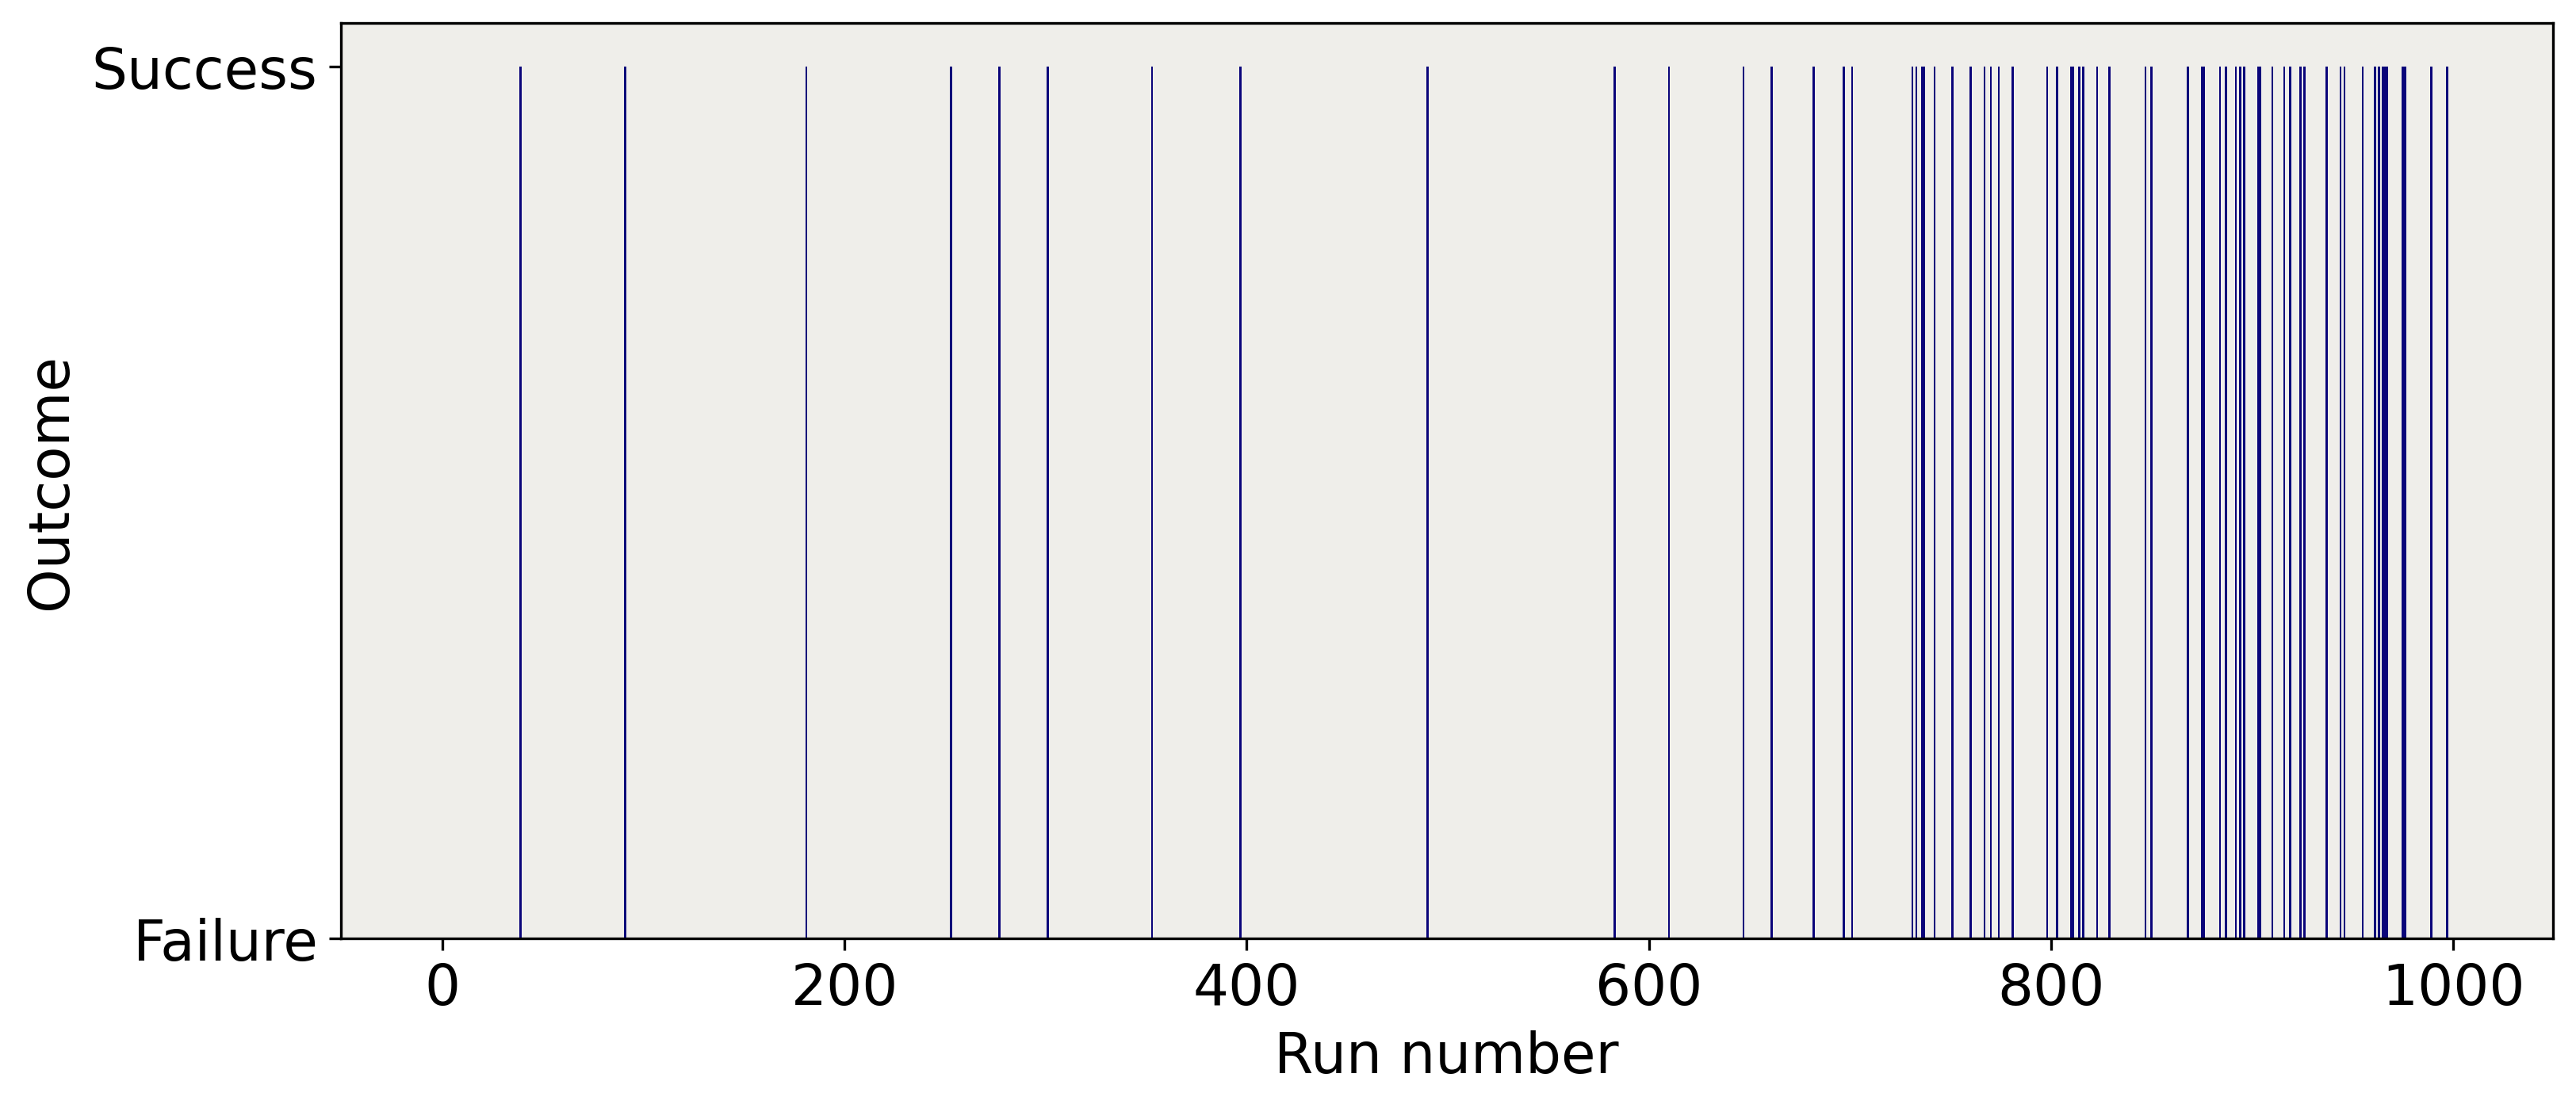

In [41]:
# Plot outcomes
plt.figure(figsize=(12, 5))
plt.xlabel("Run number")
plt.ylabel("Outcome")
ax = plt.gca()
ax.set_facecolor("#efeeea")
plt.bar(range(len(outcomes)), outcomes, color="#0A047A", width=1.0)
plt.show();

In [42]:
episodes = 100
nb_success = 0

# Evaluation
for _ in range(100):
    state = environment.reset()[0]
    terminated = False

    # Until the agent gets stuck or reaches the goal, keep training it
    while not terminated:
        # Choose the action with the highest value in the current state
        action = np.argmax(qtable[state])

        # Implement this action and move the agent in the desired direction
        new_state, reward, terminated, truncated, info = environment.step(action)

        # Update our current state
        state = new_state

        # When we get a reward, it means we solved the game
        nb_success += reward

In [43]:
# Let's check our success rate!
print(f"Success rate = {nb_success/episodes*100}%")

Success rate = 60.0%


Oof it’s not so good. But can you improve the performance by tweaking the different parameters we talked about? I encourage you to take this little challenge and do it on your own to have fun with reinforcement learning and check if you understood everything we said about Q-learning. And why not implementing exponential decay for the epsilon-greedy algorithm too? During this quick exercise, you might realise that slightly modifying the hyperparameters can completely destroy the results. This is another quirk of reinforcement learning: hyperparameters are quite moody, and it is important to understand their meaning if you want to tweak them. It’s always good to test and try new combinations to build your intuition and become more efficient. Good luck and have fun!

# 🔚 V. Conclusion

Q-learning is a simple yet powerful algorithm at the core of reinforcement learning. In this article,

- We learned to interact with the gym environment to choose actions and move our agent;
- We introduced the idea of a Q-table, where rows are states, columns are actions, and cells are the value of an action in a given state;
- We experimentally recreated the Q-learning update formula to tackle the sparse reward problem;
- We implemented an entire training and evaluation process, that solved the ❄️Frozen Lake environment with 100% success rate;
- We implemented the famous epsilon-greedy algorithm in order to create a tradeoff between the exploration of unknown state-action pairs and the exploitation of the most successful ones.

The ❄️Frozen Lake is a very simple environment, but others can have so many states and actions that it becomes impossible to store the Q-table in memory. This is especially the case in environments where events are not discrete, but continuous (like Super Mario Bros. or Minecraft). When the problem arises, a popular technique consists of training a deep neural network to approximate the Q-table. This method adds several layers of complexity, since the neural networks are not very stable. But I will cover it in another tutorial with different techniques to stabilize them.